In [9]:
import os
import math
import json
import shutil
import random
from pathlib import Path
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

In [4]:
def compute_sample_size(dataset_folder, confidence=0.95, margin_error=0.05, p=0.5):
    image_dir = os.path.join(dataset_folder, "images")
    N = len([f for f in os.listdir(image_dir)
             if f.lower().endswith((".jpg", ".jpeg", ".png"))])

    z = {0.90:1.645, 0.95:1.96, 0.99:2.576}[confidence]
    n = (N * (z**2) * p * (1-p)) / ((margin_error**2) * (N - 1) + (z**2) * p * (1-p))
    return math.ceil(n), N

In [5]:
n_tomatoes, N = compute_sample_size("../Data/tomatoes", confidence=0.95, margin_error=0.05)
print(f"Total images: {N}, required sample size: {n_tomatoes}")

Total images: 6623, required sample size: 364


In [6]:
def train_val_split(dataset_folder, val_size, random_seed=42):
    """
    Split a single COCO dataset (no prior split) into TRAIN and VAL sets.

    Input (unsplit):
        dataset/
          images/
            img_0001.png ...
          annotations/
            instances.json

    Output (created):
        dataset/
          images/
            train/
            val/
          annotations/
            instances_train.json
            instances_val.json
    """
    dataset_folder = Path(dataset_folder)
    img_dir = dataset_folder / "images"
    ann_dir = dataset_folder / "annotations"

    # 1) Locate the single COCO annotation file
    ann_candidates = [p for p in ann_dir.glob("*.json")]
    if not ann_candidates:
        raise FileNotFoundError(f"No JSON annotations found in {ann_dir}")

    coco_path = None
    coco = None
    for p in ann_candidates:
        try:
            obj = json.loads((p.read_text(encoding="utf-8")))
            if isinstance(obj, dict) and {"images","annotations","categories"} <= obj.keys():
                coco_path = p
                coco = obj
                break
        except Exception:
            continue
    if coco_path is None:
        raise ValueError("No valid COCO annotations file found (missing images/annotations/categories).")

    # Helper: resolve a file_name as stored in COCO to an absolute source path,
    # relative to the annotations file location if needed.
    def resolve_src_path(file_name: str) -> Path:
        p = Path(file_name)
        if p.is_absolute():
            return p
        # COCO file_name is relative to the JSON location in many datasets
        return (coco_path.parent / p).resolve()

    # 2) Collect image entries that actually exist on disk
    image_entries = coco.get("images", [])
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

    def exists_im(entry):
        src = resolve_src_path(entry["file_name"])
        return src.suffix.lower() in exts and src.is_file()

    image_entries = [im for im in image_entries if exists_im(im)]
    if not image_entries:
        raise ValueError("No matching images found on disk for the entries in the COCO file.")

    # 3) Build splits
    rng = random.Random(random_seed)
    indices = list(range(len(image_entries)))
    rng.shuffle(indices)

    N = len(indices)
    if 0 < val_size < 1:
        n_val = max(1, int(round(val_size * N)))
    else:
        n_val = int(val_size)
    n_val = min(max(1, n_val), N - 1)  # keep at least 1 for train

    val_idx = set(indices[:n_val])
    train_idx = set(indices[n_val:])

    val_images = [image_entries[i] for i in range(N) if i in val_idx]
    train_images = [image_entries[i] for i in range(N) if i in train_idx]

    val_image_ids = {im["id"] for im in val_images}
    train_image_ids = {im["id"] for im in train_images}

    # 4) Filter annotations per split
    anns = coco.get("annotations", [])
    val_anns = [a for a in anns if a.get("image_id") in val_image_ids]
    train_anns = [a for a in anns if a.get("image_id") in train_image_ids]

    # 5) Prepare output dirs
    (img_dir / "val").mkdir(parents=True, exist_ok=True)
    (img_dir / "train").mkdir(parents=True, exist_ok=True)

    # 6) Copy images using resolved source paths; write into images/{split}/<basename>
    def copy_images(entries, split_name):
        dst_dir = img_dir / split_name
        for im in entries:
            src = resolve_src_path(im["file_name"])
            name = src.name  # use basename to avoid duplicating subpaths like ../images/...
            dst = dst_dir / name
            if not dst.exists():
                dst.parent.mkdir(parents=True, exist_ok=True)
                shutil.copy2(src, dst)

    copy_images(val_images, "val")
    copy_images(train_images, "train")

    # 7) Build COCO dicts with updated file_name pointing from annotations/ to images/{split}/...
    def remap_images(entries, split_name):
        out = []
        for im in entries:
            src = resolve_src_path(im["file_name"])
            im2 = dict(im)
            im2["file_name"] = f"../images/{split_name}/{src.name}"
            out.append(im2)
        return out

    base = {
        "info": coco.get("info", {}),
        "licenses": coco.get("licenses", []),
        "categories": coco.get("categories", []),
    }

    val_coco = dict(base)
    val_coco["images"] = remap_images(val_images, "val")
    val_coco["annotations"] = val_anns

    train_coco = dict(base)
    train_coco["images"] = remap_images(train_images, "train")
    train_coco["annotations"] = train_anns

    # 8) Write split COCO JSONs
    with (ann_dir / "instances_val.json").open("w", encoding="utf-8") as f:
        json.dump(val_coco, f, ensure_ascii=False, indent=2)
    with (ann_dir / "instances_train.json").open("w", encoding="utf-8") as f:
        json.dump(train_coco, f, ensure_ascii=False, indent=2)

    # 9) Simple report
    summary = {
        "total_images": N,
        "val_images": len(val_coco["images"]),
        "train_images": len(train_coco["images"]),
        "val_annotations": len(val_anns),
        "train_annotations": len(train_anns),
        "random_seed": random_seed,
        "source_annotations": str(coco_path.name),
    }
    return summary


In [7]:
train_val_split("../Data/tomatoes", val_size=n_tomatoes, random_seed=42)

{'total_images': 6623,
 'val_images': 364,
 'train_images': 6259,
 'val_annotations': 2479,
 'train_annotations': 42465,
 'random_seed': 42,
 'source_annotations': 'instances.json'}

In [11]:
def visualize_random_coco_images(
    dataset_root, 
    split="train", 
    num_samples=3, 
    seed=42
):
    """
    Display random COCO images with bounding boxes and category labels.

    Args:
        dataset_root (str | Path): Path to dataset root (containing 'images/' and 'annotations/').
        split (str): 'train' or 'val', determines which annotation file to load.
        num_samples (int): Number of random images to display.
        seed (int): Random seed for reproducibility.
    """
    dataset_root = Path(dataset_root)
    ann_path = dataset_root / "annotations" / f"instances_{split}.json"
    ann_dir = ann_path.parent

    if not ann_path.exists():
        raise FileNotFoundError(f"Annotation file not found: {ann_path}")

    with open(ann_path, "r", encoding="utf-8") as f:
        coco = json.load(f)

    cats = {c["id"]: c["name"] for c in coco["categories"]}
    images = {img["id"]: img for img in coco["images"]}
    anns = coco["annotations"]

    # group annotations by image_id
    ann_by_img = {}
    for a in anns:
        ann_by_img.setdefault(a["image_id"], []).append(a)

    # random image selection
    rng = random.Random(seed)
    sample_ids = rng.sample(list(images.keys()), min(num_samples, len(images)))

    for img_id in sample_ids:
        img_info = images[img_id]
        img_path = (ann_dir / img_info["file_name"]).resolve()

        if not img_path.exists():
            print(f"Missing: {img_path}")
            continue

        im = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(im)

        for a in ann_by_img.get(img_id, []):
            if "bbox" not in a:
                continue
            x, y, w, h = a["bbox"]
            cat = cats.get(a["category_id"], "")
            draw.rectangle([x, y, x + w, y + h], outline="red", width=2)
            draw.text((x, y), cat, fill="red")

        plt.figure(figsize=(8, 8))
        plt.imshow(im)
        plt.axis("off")
        plt.title(img_info["file_name"])
        plt.show(block=False)

    plt.show()


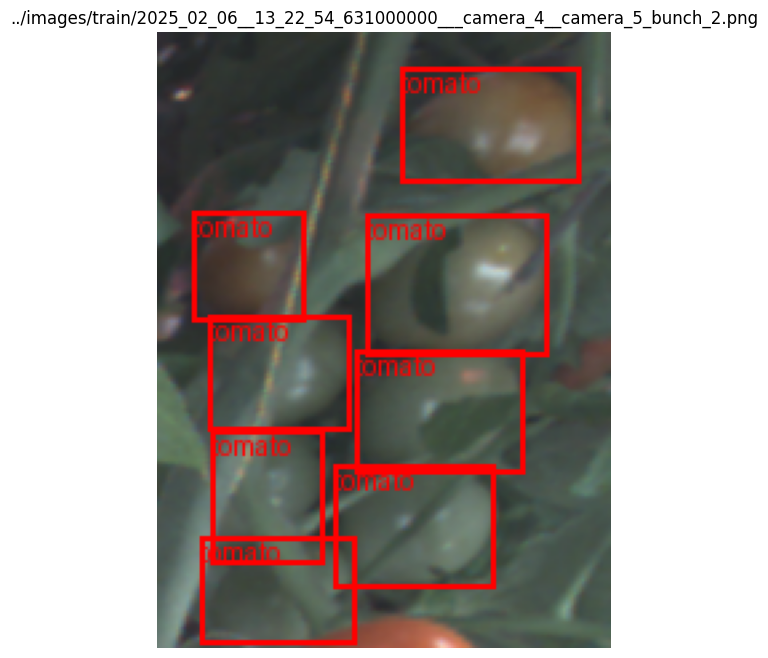

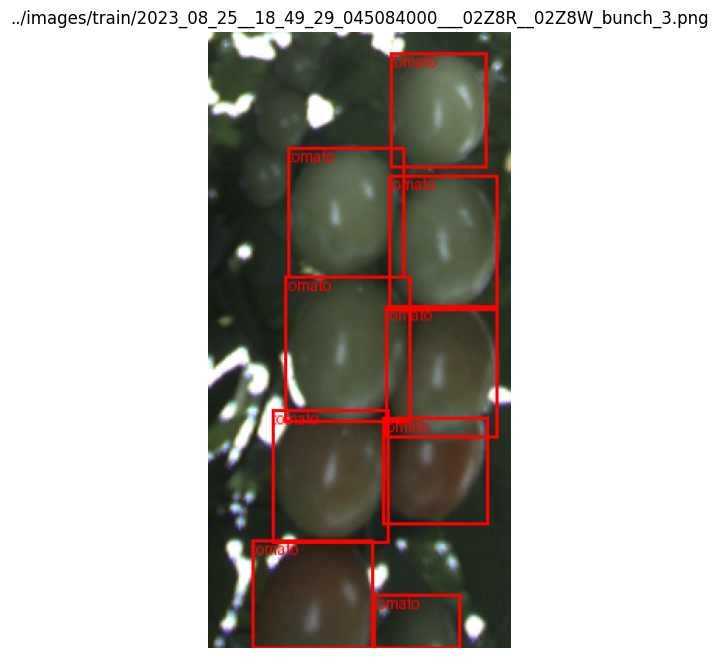

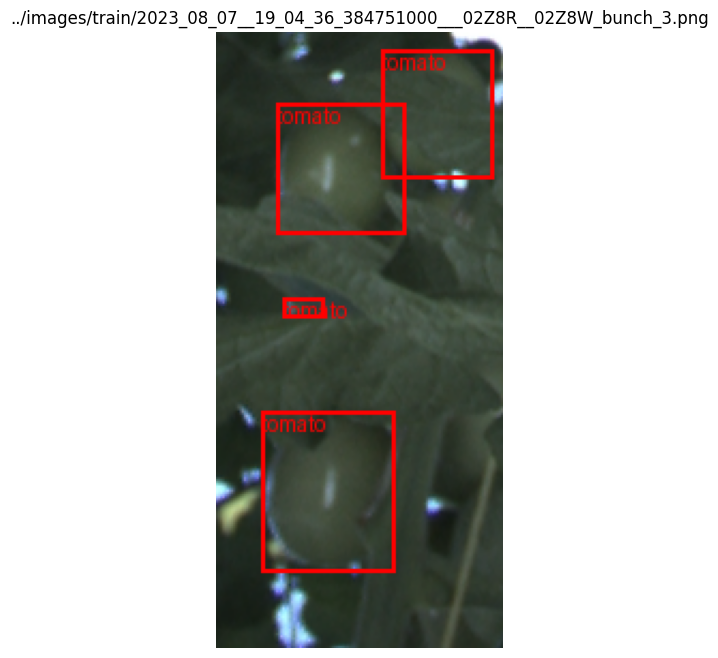

In [12]:
visualize_random_coco_images("../Data/tomatoes", split="train", num_samples=3)


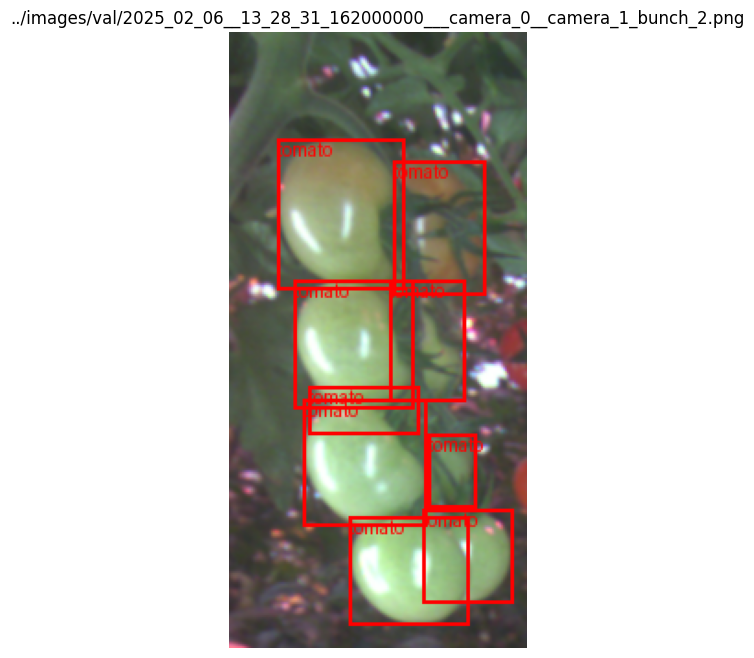

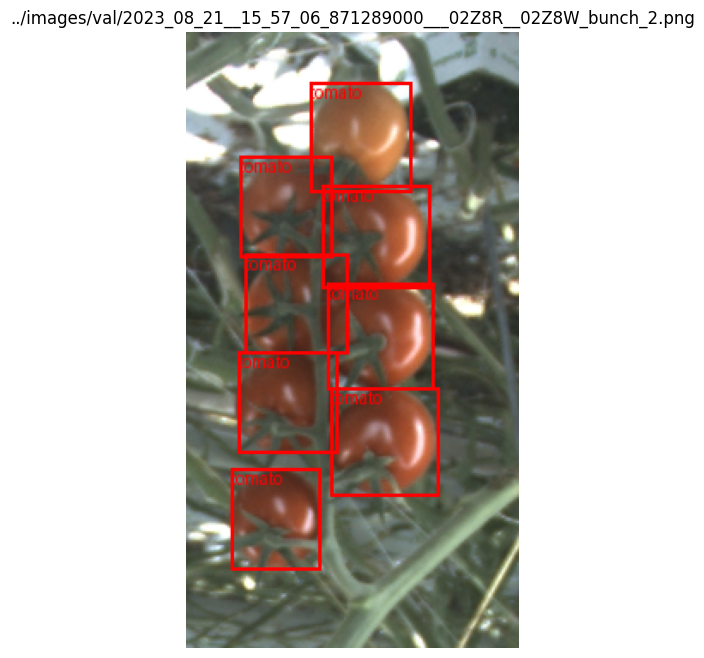

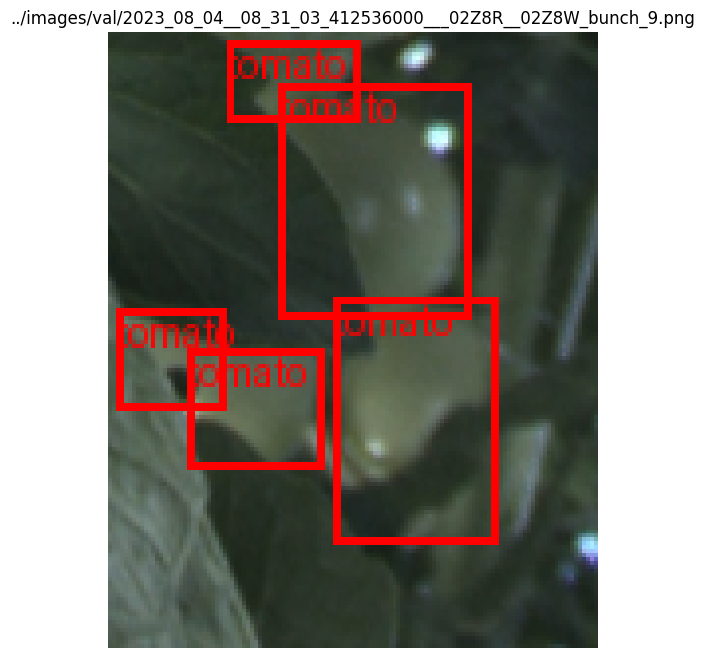

In [13]:
visualize_random_coco_images("../Data/tomatoes", split="val", num_samples=3)
